## Expectation-Maximization Algorithm

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})
np.random.seed(1)

In [2]:
# helper functions

def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) / np.sqrt(2 * np.pi) / sigma

def loglikelihood_single_gaussian(X, mu, sigma):
    N = X.shape[0]
    ll = - 1.* N / 2 * np.log(2 * np.pi * sigma**2) - 1./ (2 * sigma**2) * (X - mu).sum()
    return ll

def plot_lls(lls, ax=None):
    ax = ax or plt.gca()
    ax.plot(lls)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Objective function')
    plt.tight_layout()
    plt.show()

In [3]:
# data preparation
X1 = np.random.normal(loc=170, scale=5, size=10000)
X2 = np.random.normal(loc=200, scale=15, size=20000)
X = np.concatenate((X1, X2))

<IPython.core.display.Javascript object>


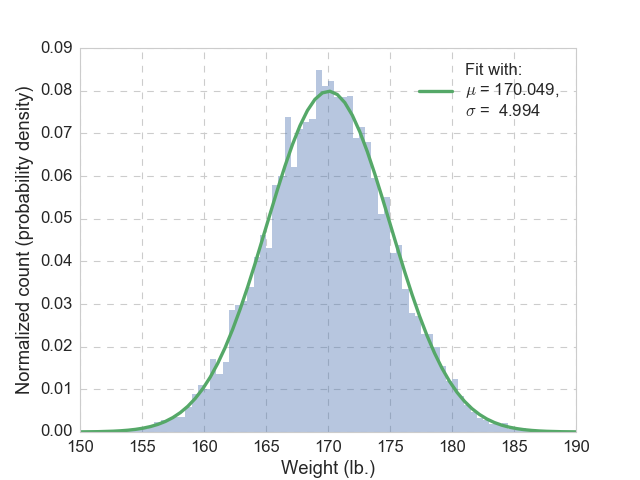

The mean and the std are 170.049,  4.994


In [4]:
plt.figure(0)
# make the histogram
ax = sns.distplot(X1,bins=np.arange(140,200,0.5), norm_hist=True, 
             kde=False, hist_kws={"linewidth": 0})
# plot the gaussian pdf
x = np.linspace(140, 260, 200)
mu, sigma = X1.mean(), X1.std()
y1 = gaussian(x=x, mu=mu, sigma=sigma)
ax.plot(x, y1, lw=3, label='Fit with: \n$\mu$ = {0:6.3f}, \n$\sigma$ = {1:6.3f}'.format(mu, sigma))
ax.set_xlabel('Weight (lb.)')
ax.set_ylabel('Normalized count (probability density)')
plt.xlim([150, 190])
plt.legend()
plt.show()
print('The mean and the std are {0:6.3f}, {1:6.3f}'.format(mu, sigma))

<IPython.core.display.Javascript object>


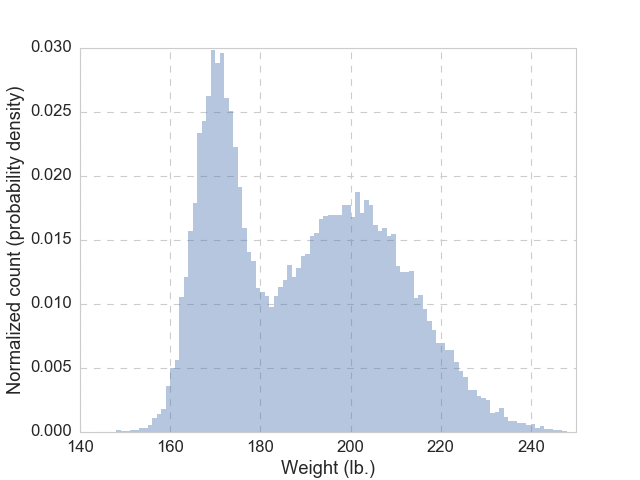

In [5]:
def plot_hist_and_fits(X, mus=None, sigmas=None, pis=None, fig_num=1, 
                       fits=False, save_fig=False, title=''):
    plt.figure(fig_num)
    
    # make the histogram
    ax = sns.distplot(X,bins=np.arange(140,250,1), norm_hist=True,
                 kde=False, hist_kws={"linewidth": 0})
    plt.xlim([140, 250])
    # make the gaussian pdfs
    if fits:
        k = len(mus)
        x = np.linspace(start=X.min()-10, stop=X.max()+5, num=200)
        y_mixture = None
        for j in range(k):
            y = gaussian(x=x, mu=mus[j], sigma=sigmas[j]) * pis[j]
            ax.plot(x, y, '--')
            if y_mixture is None:
                y_mixture = y[:]
            else:
                y_mixture += y
        ax.plot(x, y_mixture)
    ax.set_xlabel('Weight (lb.)')
    ax.set_ylabel('Normalized count (probability density)')
    plt.title(title)
    
    if not save_fig:
        plt.show()
    else:
        plt.savefig('figure_{}.png'.format(fig_num))
        plt.close(fig_num)

plot_hist_and_fits(X)

## EM algorithm for 1D case
<a name="EM"></a>

In [6]:
def loglikelihoods(X, mus, sigmas, pis):
    N = X.shape[0]
    k = len(mus)
    
    ll = 0
    # brute force double-for-loops
    for i in range(N):
        ll_single = 0
        for j in range(k):
            ll_single += pis[j] * np.exp( loglikelihood_single_gaussian(
                                            X=X[i:i+1], mu=mus[j], sigma=sigmas[j]) )
        ll += np.log(ll_single)
    return ll

def e_step(X, mus, sigmas, pis):
    N = X.shape[0]
    k = len(mus)
    ws = np.ndarray(shape=(k, N), dtype=float)
    
    # calculate likelihood * prior
    for j in range(k):
        ws[j] = gaussian(X, mus[j], sigmas[j]) * pis[j]
    
    # normalize by marginal
    ws /= ws.sum(axis=0)
    
    return ws

def m_step(X, ws):
    N = X.shape[0]
    k = len(ws)
    mus    = np.zeros(k)
    sigmas = np.zeros(k)
    pis    = np.zeros(k) 
    
    for j in range(k):
        pis[j]    = ws[j].sum() / N
        mus[j]    = np.dot(X, ws[j]) / ws[j].sum()
        sigmas[j] = np.dot(np.power(X - mus[j], 2), ws[j]) / ws[j].sum()
    
    sigmas = np.sqrt(sigmas)       
    return mus, sigmas, pis


def EM(X, mus_init, sigmas_init, pis_init, max_iter=1000, thres=1e-3, make_plots=False):    
    mus, sigmas, pis = mus_init, sigmas_init, pis_init
    ll = loglikelihoods(X, mus, sigmas, pis)
    lls = [ll]
    
    for i in range(1, 1+max_iter):
        if make_plots:
            plot_hist_and_fits(X, mus, sigmas, pis, 
                        fig_num=i, fits=True, save_fig=True, 
                        title='Iteration {}'.format(i))
        verbose_step = 10
        if i % verbose_step == 0:
            print("Iter {}, latest log-likelihood {}".format(i, ll))
                       
        # e step
        ws = e_step(X, mus, sigmas, pis)
        
        # m step
        mus, sigmas, pis = m_step(X, ws)
        
        # calculate log-likelihoods
        ll_latest = loglikelihoods(X, mus, sigmas, pis)
        lls.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if abs(ll_latest - ll) < thres and ll_latest > -np.inf:
            print("Converged before max iteration.")
            break
        ll = ll_latest
           
    return mus, sigmas, pis, lls

In [7]:
mus_init    = np.array([150, 240])
sigmas_init = np.array([20, 30])
pis_init    = np.array([0.5, 0.5])
mus, sigmas, pis, lls = EM(X, mus_init, sigmas_init, pis_init, max_iter=300)
# convert -background white -alpha remove -layers OptimizePlus -delay 30 figure_{1..9}.png 
# figure_{10..20}.png EM_gaussian_mixture.gif

Iter 10, latest log-likelihood -97290.19121030968
Iter 20, latest log-likelihood -98706.32746080356
Iter 30, latest log-likelihood -99234.71922961327
Iter 40, latest log-likelihood -99363.47792470583
Iter 50, latest log-likelihood -99393.45457154552
Iter 60, latest log-likelihood -99400.37281995219
Iter 70, latest log-likelihood -99401.96638689363
Iter 80, latest log-likelihood -99402.33329142963
Iter 90, latest log-likelihood -99402.41775936497
Converged before max iteration.


In [8]:
print("mus:    ", mus)
print("sigmas: ", sigmas)
print("pis:    ", pis)

mus:     [ 170.03165133  199.86172799]
sigmas:  [  4.95710479  15.05202711]
pis:     [ 0.33091704  0.66908296]


## Get probabilities
<a name="get_probs"></a>

In [9]:
probs = gaussian(np.asarray([180]), mus, sigmas) * pis
probs /= probs.sum()
print(probs)

[ 0.32198567  0.67801433]


## Gradient descent of single Gaussian distribution
<a name="GD"></a>

In [10]:
## gradient descent
def gd_single_gaussian(X, mu_i, sig_i, max_iter=1e4, learning_rate=0.2):
    mu, var = mu_i, sig_i**2
    mus, vars_, lls = [], [], []
    N = X.shape[0]
    for i in range(1, int(max_iter)+1):
        ll = loglikelihood_single_gaussian(X, mu, np.sqrt(var))
        
        # learning rate decay
        if i % 500 == 0:
            learning_rate = .75 * learning_rate 

        d_mu = 1. / var * (X - mu).sum()
        d_var = - 1.*N / 2 / var + (np.square(X - mu)).sum() / 2 / var**2
        # update mu, var
        mu = mu + learning_rate * d_mu
        var = var + learning_rate * d_var
        
        if var < 0:
            raise Exception('var is negative: ', var)
        
        mus.append(mu)
        vars_.append(var)
        lls.append(ll)
        
    return mus, vars_, lls

mus, vars_, lls = gd_single_gaussian(X1, 150, 25)
print(mus[-1], vars_[-1])

170.048863283 24.9393290388


<IPython.core.display.Javascript object>


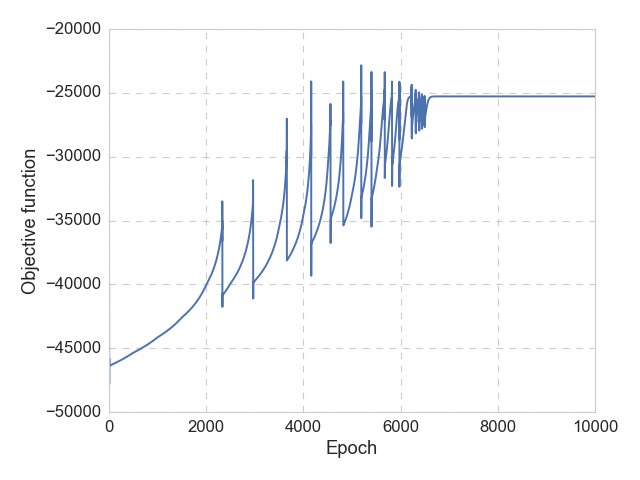

In [11]:
plt.figure(50)
plot_lls(lls)